In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
cd ../../sd_foregrounds/

/mnt/zfsusers/mabitbol/sd_foregrounds


In [5]:
import fisher
import spectral_distortions as sd
import foregrounds as fg

In [6]:
import emcee 
import corner

In [7]:
fmin = 82.5e9
p0 = {}
fsky = 1.
sigs = [sd.DeltaI_reltSZ_2param_yweight, sd.DeltaI_DeltaT, \
        fg.thermal_dust_rad, fg.cib_rad, fg.jens_freefree_rad, \
        fg.jens_synch_rad, fg.co_rad]

AttributeError: 'module' object has no attribute 'thermal_dust_rad'

In [ ]:
bx = 30. * (12. / 8760) # months
fish = fisher.FisherEstimation(duration=bx, fmin=fmin, fsky=fsky, priors=p0, bandpass=False)
fish.set_signals(sigs)
fish.run_fisher_calculation()
fish.print_errors()

In [8]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [9]:
def lnlike(theta, x, y, yerr):
    y_tot, kt, dt, ad, bd, td, ac, bc, tc, em, As, alps, w2s, aco = theta
    model = sd.DeltaI_reltSZ_2param_yweight(x, y_tot, kt)
    model += sd.DeltaI_DeltaT(x, dt)
    model += fg.thermal_dust_rad(x, ad, bd, td)
    model += fg.cib_rad(x, ac, bc, tc)
    model += fg.jens_freefree_rad(x, em)
    model += fg.jens_synch_rad(x, As, alps, w2s)
    model += fg.co_rad(x, aco)
    return -0.5 * (np.sum((y-model)**2. * yerr**-2.))

In [10]:
def lnprior(theta):
    return 0.

# CMB Baseline

In [11]:
fmin = 82.5e9
p0 = {}
fsky = 1.
sigs = [sd.DeltaI_reltSZ_2param_yweight, sd.DeltaI_DeltaT]

In [12]:
bx = 30. * (12. / 8760) # months
fish = fisher.FisherEstimation(duration=bx, fmin=fmin, fsky=fsky, priors=p0, bandpass=False)
fish.set_signals(sigs)
fish.run_fisher_calculation()
fish.print_errors()

y_tot 158.2807512859942
kT_yweight 3.137952172980297
DeltaT_amp 7305.361239400169


In [13]:
x = fish.center_frequencies
noise = fish.noise
y = np.zeros(len(x))
for sig in sigs:
    y += sig(x)
yerr = noise*np.random.randn(len(x))
#y += yerr

In [14]:
def lnlike(theta, x, y, yerr):
    y_tot, kt, dt = theta
    model = sd.DeltaI_reltSZ_2param_yweight(x, y_tot, kt)
    model += sd.DeltaI_DeltaT(x, dt)
    return -0.5 * (np.sum((y-model)**2. * yerr**-2.))

In [15]:
ndim, nwalkers, nsteps = 3, 64, 1000
pos = [fish.p0*(1. + 1.e-1*np.random.randn(ndim)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, noise))
sampler.run_mcmc(pos, nsteps);

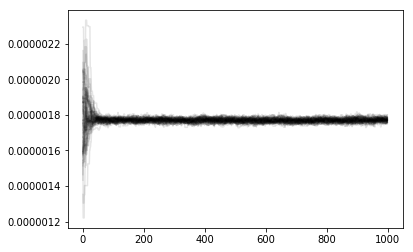

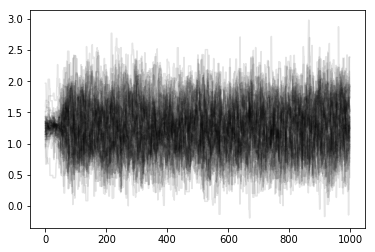

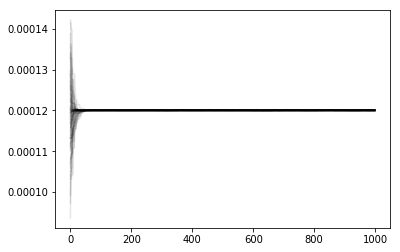

In [16]:
for k in range(ndim):
    figure()
    plot(sampler.chain[:,:,k].T, color='k', alpha=0.1);

In [17]:
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))

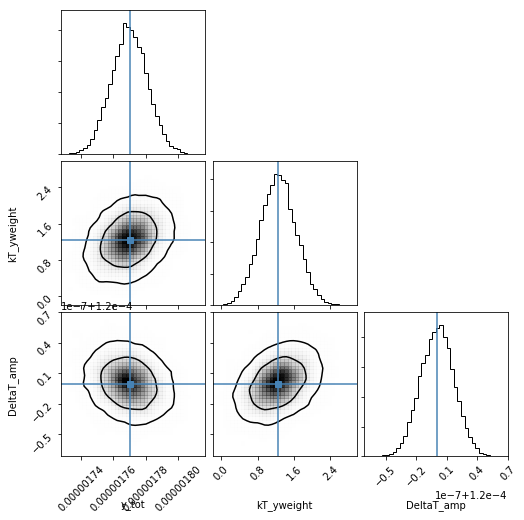

In [18]:
fig = corner.corner(samples, truths=fish.p0, plot_datapoints=False, bins=40, 
                    levels=[0.68,0.95], smooth=1., labels=fish.args)

In [19]:
[(arg, fish.errors[arg]) for arg in fish.args]

[('y_tot', 1.1182661098201535e-08),
 ('kT_yweight', 0.396755569036462),
 ('DeltaT_amp', 1.642629242655398e-08)]

In [20]:
p_mc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
for k in range(len(p_mc)):
    print (p_mc[k][1]+p_mc[k][2])/2.

1.1159248268117877e-08
0.39306279232653163
1.6461950087314707e-08


# CMB and a few foregrounds

In [131]:
fmin = 82.5e9
p0 = {}
fsky = 1.
sigs = [sd.DeltaI_y, sd.DeltaI_DeltaT, \
        fg.thermal_dust_rad, fg.jens_synch_rad1]

In [132]:
bx = 30. * (12. / 8760) # months
fish = fisher.FisherEstimation(duration=bx, fmin=fmin, fsky=fsky, priors=p0, bandpass=False)
fish.set_signals(sigs)
fish.run_fisher_calculation()
fish.print_errors()

y_tot 91.67125636549014
DeltaT_amp 2282.034303697621
Ad 19479.145714199683
Bd 46324.63909872345
Td 126261.28219265322
As 4.797670418839193
alps 1.6233898048058457


In [133]:
x = fish.center_frequencies
noise = fish.noise
y = np.zeros(len(x))
for sig in sigs:
    y += sig(x)
yerr = noise*np.random.randn(len(x))
#y += yerr

In [134]:
fish.args

array(['y_tot', 'DeltaT_amp', 'Ad', 'Bd', 'Td', 'As', 'alps'],
      dtype='|S32')

In [135]:
fish.p0

array([ 1.77e-06,  1.20e-04,  1.36e+06,  1.53e+00,  2.10e+01,  2.88e+02,
       -8.20e-01])

In [136]:
def lnlike(theta, x, y, yerr):
    y_tot, dt, ad, bd, td, As, alps = theta
    model = sd.DeltaI_y(x, y_tot)
    model += sd.DeltaI_DeltaT(x, dt)
    model += fg.thermal_dust_rad(x, ad, bd, td)
    model += fg.jens_synch_rad1(x, As, alps)
    return -0.5 * (np.sum((y-model)**2. * yerr**-2.))

In [137]:
def lnprior(theta):
    y_tot, dt, ad, bd, td, As, alps = theta
    
    if np.abs(y_tot) >= 1.:
        return -np.inf
    if np.abs(dt) >= 1.:
        return -np.inf
    if ad < 0:
        return -np.inf
    if As < 0:
        return -np.inf
    if bd <= 0:
        return -np.inf
    if td < 10 or td > 100:
        return -np.inf
    #if alps > 0:
        #return -np.inf
    return 0.

In [138]:
ndim, nwalkers, nsteps = len(fish.args), 256, 10000
pos = [fish.p0*(1. + 1.e-2*np.random.randn(ndim)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, noise))
sampler.run_mcmc(pos, nsteps);

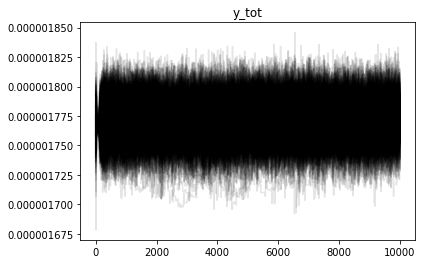

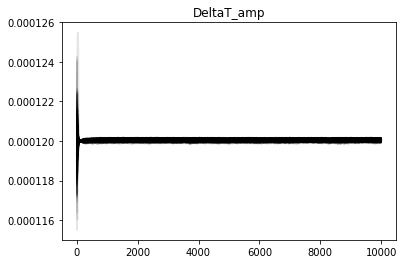

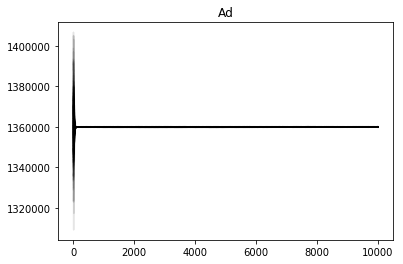

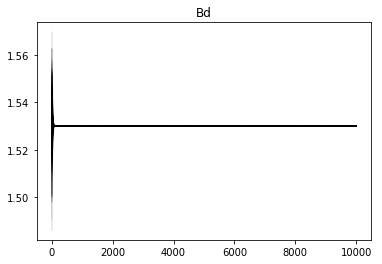

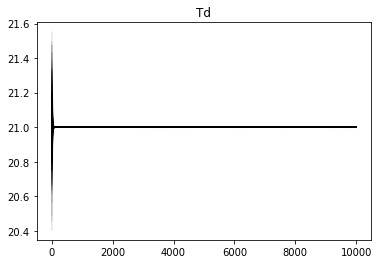

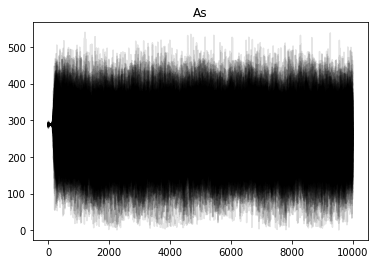

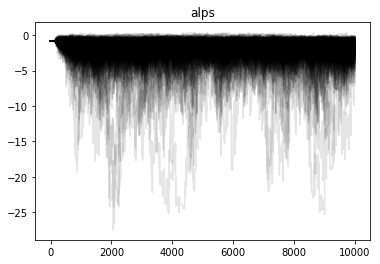

In [139]:
for k in range(ndim):
    figure()
    title(fish.args[k])
    plot(sampler.chain[:,:,k].T, color='k', alpha=0.1);

In [140]:
samples = sampler.chain[:, 4000:, :].reshape((-1, ndim))

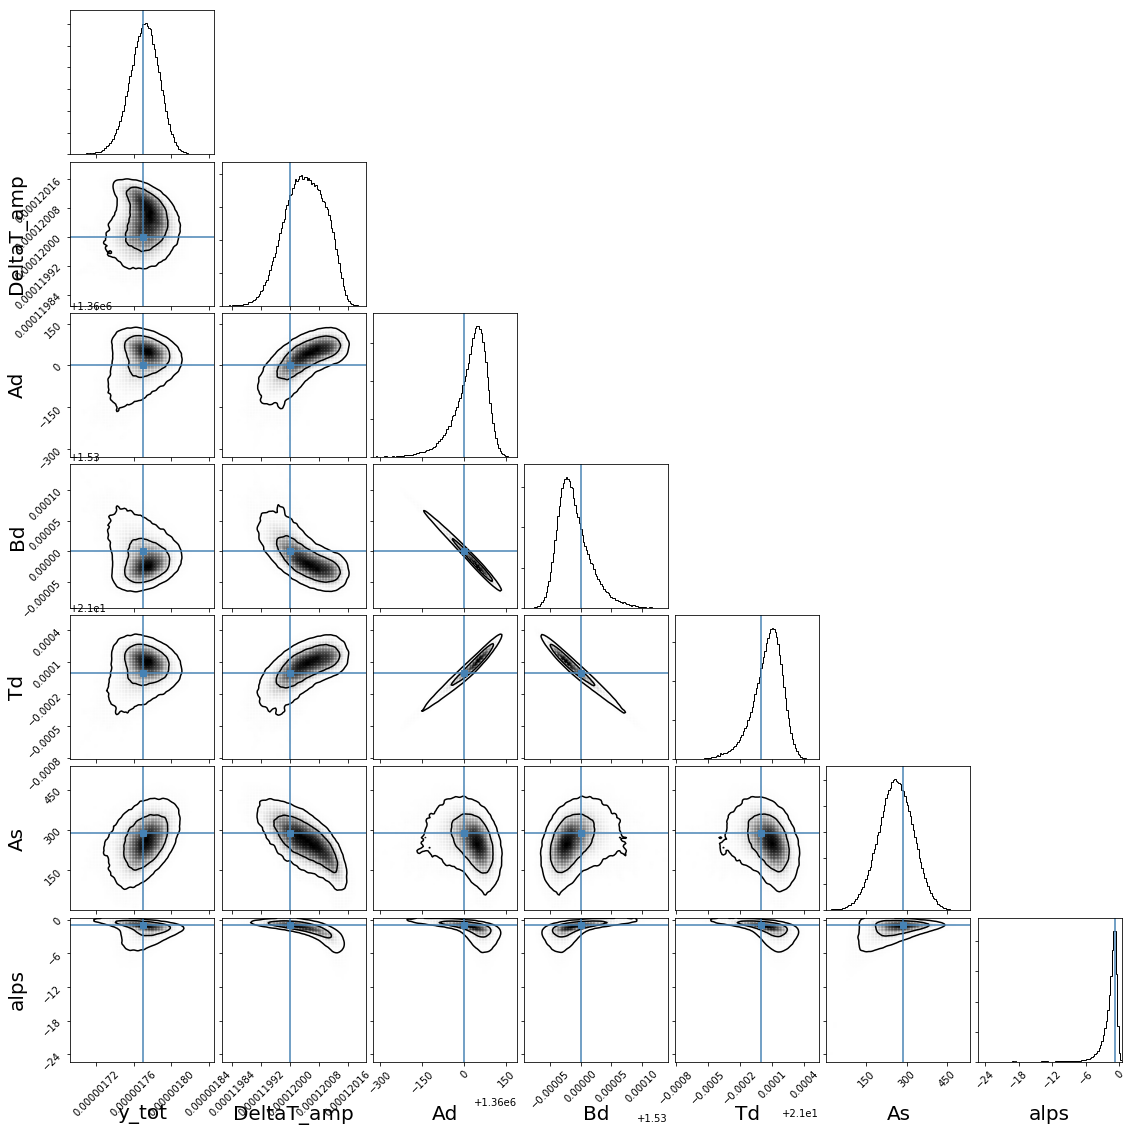

In [141]:
fig = corner.corner(samples, truths=fish.p0, plot_datapoints=False, bins=100, 
                    levels=[0.68,0.95], smooth=1., labels=fish.args, label_kwargs=dict(fontsize=20))

In [142]:
[(arg, fish.errors[arg]) for arg in fish.args]

[('y_tot', 1.9308124162093634e-08),
 ('DeltaT_amp', 5.258466089031259e-08),
 ('Ad', 69.81825691711947),
 ('Bd', 3.3027780243239105e-05),
 ('Td', 0.00016632177050093295),
 ('As', 60.02913390405051),
 ('alps', 0.5051158985799288)]

In [143]:
p_mc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
for k in range(len(p_mc)):
    print fish.p0[k], p_mc[k][0], (p_mc[k][1]+p_mc[k][2])/2.

1.77e-06 1.771437196140059e-06 1.57242385749044e-08
0.00012 0.00012004135536295863 5.83428513715591e-08
1360000.0 1360033.3659008176 53.03195062070154
1.53 1.5299842874662246 2.5537215818993708e-05
21.0 21.000070980080956 0.00013320866105459572
288.0 259.8360440390642 65.84020767183245
-0.82 -1.2746207245291106 0.9851289422497738
